##Preprocessing

In [1]:
pip install monai==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [2]:
pip install dicom2nifti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 76.7 MB/s eta 0:00:00


In [3]:
pip install self-attention-cv==1.2.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00


In [4]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AddChanneld,
    AsDiscrete,
    CenterSpatialCropd,
    CropForegroundd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    Spacingd,
    ScaleIntensityRanged,
    ToTensord,
)
from monai.utils import set_determinism

import torch

In [5]:
from glob import glob
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=1000, a_max=1500, spatial_size=[128,128,128], cache=False):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [6]:
import matplotlib.pyplot as plt

In [7]:
pip install first

In [8]:
import first

In [10]:
in_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
patient = prepare(in_dir)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

In [12]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
import torch

##Training

In [13]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def calculate_iou(predicted, target):
    iouvalue = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True, jaccard=True)
    iou_value = 1-iouvalue(predicted,target).item()
    return iou_value

In [14]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_iou_train = []
    save_iou_test = []
    train_loader, test_loader = data_in

    # Initialize the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        epoch_iou_train = 0

        for batch_data in train_loader:
            train_step += 1
            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                  f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

            train_iou = calculate_iou(outputs, label)
            epoch_iou_train += train_iou
            print(f'Train_IoU: {train_iou:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')
        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        epoch_iou_train /= train_step
        print(f'Epoch_IoU: {epoch_iou_train:.4f}')
        save_iou_train.append(epoch_iou_train)
        np.save(os.path.join(model_dir, 'iou_train.npy'), save_iou_train)

        # Update the scheduler with the current epoch_metric_train
        scheduler.step(epoch_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0
                test_iou = 0
                epoch_iou_test = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    test_iou = calculate_iou(test_outputs, test_label)
                    epoch_iou_test += test_iou

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                epoch_iou_test /= test_step
                print(f'test_iou_epoch: {epoch_iou_test:.4f}')
                save_iou_test.append(epoch_iou_test)
                np.save(os.path.join(model_dir, 'iou_test.npy'), save_iou_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [16]:
data_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
model_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/NEW result 128 UNETR'
data_in = prepare(data_dir, cache=False)

from self_attention_cv import UNETR
device = torch.device("cuda:0")
num_heads = 12 # 12 normally
embed_dim = 768 # 768 normally

roi_size=[128, 128, 128]
model = UNETR(img_shape=tuple(roi_size), input_dim=1, output_dim=2,
              embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
              ext_layers=[3, 6, 9, 12],
              norm='instance',
              base_filters=16,
              dropout=0.1,
              dim_linear_block=2048).to(device)

from monai.losses import DiceFocalLoss
#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
loss_function = DiceFocalLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
train(model, data_in, loss_function, optimizer, 500, model_dir)

Streaming output truncated to the last 5000 lines.
Train_IoU: 0.9757
6/16, Train_loss: 0.0178
Train_dice: 0.9870
Train_IoU: 0.9746
7/16, Train_loss: 0.0179
Train_dice: 0.9875
Train_IoU: 0.9755
8/16, Train_loss: 0.0139
Train_dice: 0.9885
Train_IoU: 0.9774
9/16, Train_loss: 0.0149
Train_dice: 0.9877
Train_IoU: 0.9759
10/16, Train_loss: 0.0181
Train_dice: 0.9858
Train_IoU: 0.9722
11/16, Train_loss: 0.0185
Train_dice: 0.9867
Train_IoU: 0.9740
12/16, Train_loss: 0.0172
Train_dice: 0.9863
Train_IoU: 0.9733
13/16, Train_loss: 0.0162
Train_dice: 0.9863
Train_IoU: 0.9732
14/16, Train_loss: 0.0166
Train_dice: 0.9882
Train_IoU: 0.9768
15/16, Train_loss: 0.0196
Train_dice: 0.9857
Train_IoU: 0.9720
16/16, Train_loss: 0.0214
Train_dice: 0.9843
Train_IoU: 0.9693
--------------------
Epoch_loss: 0.0172
Epoch_metric: 0.9869
Epoch_IoU: 0.9744
test_loss_epoch: 0.0368
test_dice_epoch: 0.9744
test_iou_epoch: 0.9510
current epoch: 416 current mean dice: 0.9733
best mean dice: 0.9760 at epoch: 151
----------

##Testing

In [17]:
import numpy as np
import os
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))
train_iou = np.load(os.path.join(model_dir, 'iou_train.npy'))
test_iou = np.load(os.path.join(model_dir, 'iou_test.npy'))

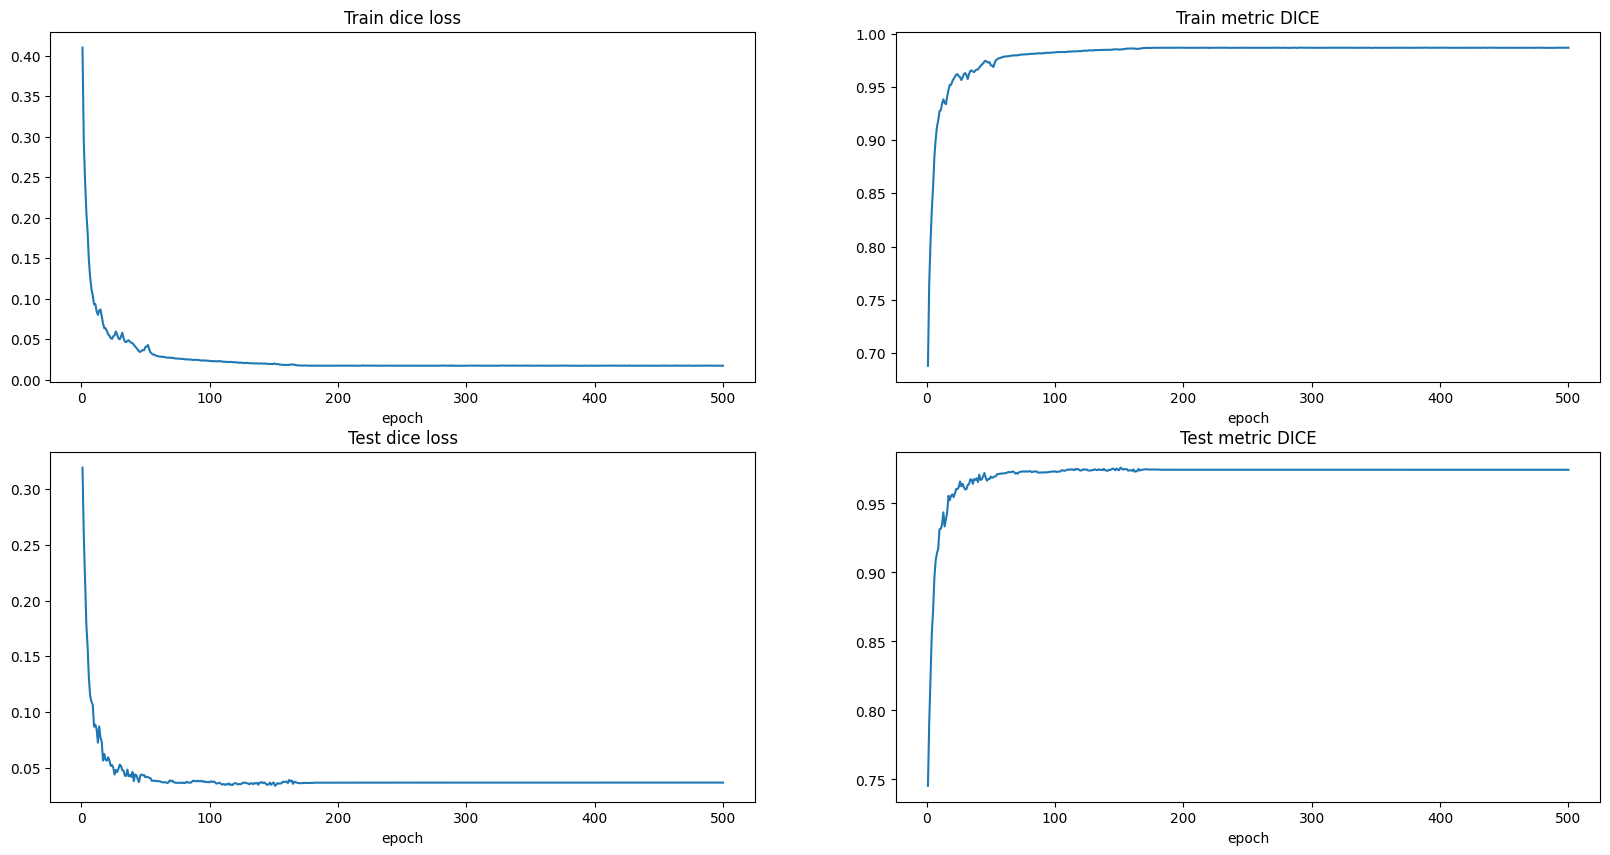

In [ ]:
plt.figure("Evaluate", (20, 10))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

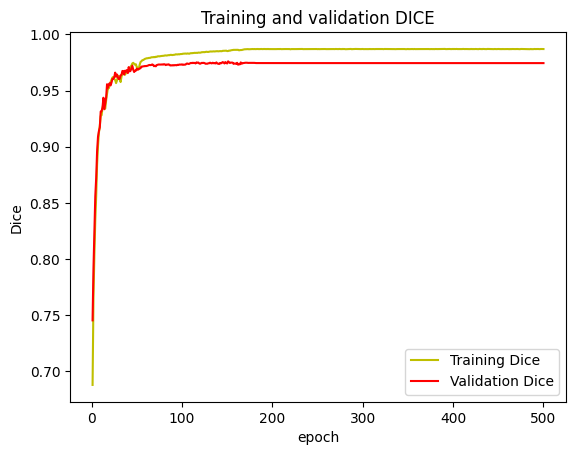

In [ ]:
# Plot training and validation dice
plt.title("Training and validation DICE")
dice = train_metric
val_dice = test_metric
epochs = [i + 1 for i in range(len(train_metric))]
plt.plot(epochs, dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.xlabel("epoch")
plt.ylabel("Dice")
plt.legend()
plt.show()

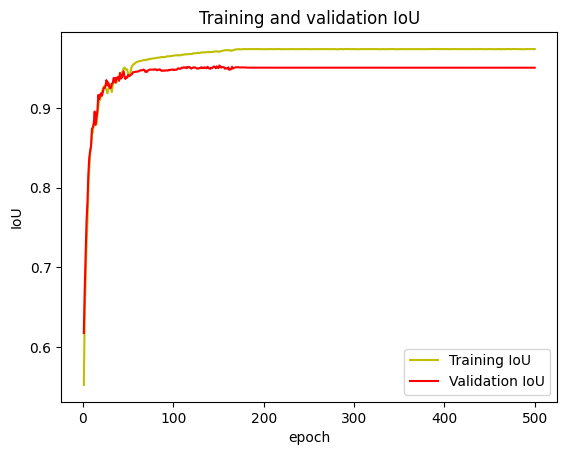

In [ ]:
# Plot training and validation IOU
plt.title("Training and validation IoU")
iou = train_iou
val_iou = test_iou
epochs = [i + 1 for i in range(len(train_iou))]
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

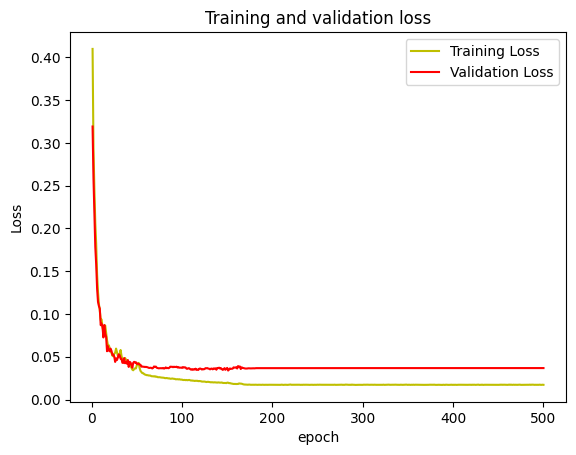

In [ ]:
# Plot training and validation loss
plt.title("Training and validation loss")
loss = train_loss
val_loss = test_loss
epochs = [i + 1 for i in range(len(train_loss))]
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
in_dir = data_dir
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:4]

In [19]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=1000, a_max=1500,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [20]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [21]:
device = torch.device("cuda:0")
model = UNETR(img_shape=tuple(roi_size), input_dim=1, output_dim=2,
              embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
              ext_layers=[3, 6, 9, 12],
              norm='instance',
              base_filters=16,
              dropout=0.1,
              dim_linear_block=2048).to(device)

In [22]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNETR(
  (embed): Embeddings3D(
    (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16), bias=False)
    (position_embeddings): AbsPositionalEncoding1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layer): ModuleList()
    (block_list): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mhsa): MultiHeadSelfAttention(
          (to_qvk): Linear(in_features=768, out_features=2304, bias=False)
          (W_0): Linear(in_features=768, out_features=768, bias=False)
        )
        (drop): Dropout(p=0.1, inplace=False)
        (norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (linear): Sequential(
          (0): Linear(in_features=768, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=2048, out_features=768, bias=True)

In [23]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.inferers import sliding_window_inference

In [24]:
pip install torchsummary

In [ ]:
from torchsummary import summary

# Assuming model is already defined
summary(model, input_size=(1, roi_size[0], roi_size[1], roi_size[2]))  # Assuming 'roi_size' is a tuple of dimensions

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [-1, 768, 8, 8, 8]       3,145,728
AbsPositionalEncoding1D-2             [-1, 512, 768]               0
           Dropout-3             [-1, 512, 768]               0
      Embeddings3D-4             [-1, 512, 768]               0
         LayerNorm-5             [-1, 512, 768]           1,536
            Linear-6            [-1, 512, 2304]       1,769,472
            Linear-7             [-1, 512, 768]         589,824
MultiHeadSelfAttention-8             [-1, 512, 768]               0
           Dropout-9             [-1, 512, 768]               0
        LayerNorm-10             [-1, 512, 768]           1,536
           Linear-11            [-1, 512, 2048]       1,574,912
             GELU-12            [-1, 512, 2048]               0
          Dropout-13            [-1, 512, 2048]               0
           Linear-14          

In [ ]:
pip install torchinfo

In [ ]:
sw_batch_size = 4
roi_size = (128, 128, 128)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        plt.show()

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
from monai.transforms import Activations
from monai.inferers import sliding_window_inference

# Assuming your model is already defined and loaded into the 'model' variable.
# Also, assuming 'test_loader' is your DataLoader.

sw_batch_size = 4
roi_size = (128, 128, 128)

# Get a sample from the test_loader
with torch.no_grad():
    test_patient = next(iter(test_loader))
    t_volume = test_patient['vol'].to(device)

    # Measure inference time
    start_time = time.time()

    # Inference
    test_outputs = sliding_window_inference(t_volume, roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f"Inference time: {elapsed_time} seconds")

    # Visualization (assuming you have 'seg' in your test_patient)
    #for i in range(128):
        # plot the slice [:, :, 80]
        #plt.figure("check", (18, 6))
        #plt.subplot(1, 3, 1)
        #plt.title(f"image {i}")
        #plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        #plt.subplot(1, 3, 2)
        #plt.title(f"label {i}")
        #plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        #plt.subplot(1, 3, 3)
        #plt.title(f"output {i}")
        #plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        #plt.show()

Inference time: 1.2559726238250732 seconds


In [ ]:
# Load the best model checkpoint
best_model_path = os.path.join(model_dir, "best_metric_model.pth")
best_model = UNETR(img_shape=tuple(roi_size), input_dim=1, output_dim=2,
              embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
              ext_layers=[3, 6, 9, 12],
              norm='instance',
              base_filters=16,
              dropout=0.1,
              dim_linear_block=2048).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

def evaluate(model, dataloader, loss_function, device=torch.device("cuda:0")):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_data in dataloader:
            inputs = batch_data["vol"].to(device)
            labels = batch_data["seg"].to(device)
            labels = labels != 0  # Assuming binary segmentation

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            total_loss += loss.item()

            # Compute your evaluation metric (e.g., dice coefficient)
            metric = dice_metric(outputs, labels)
            total_metric += metric

            # Compute IoU
            iou = calculate_iou(outputs, labels)
            total_iou += iou

            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    average_metric = total_metric / total_samples
    average_iou = total_iou / total_samples

    return average_loss, average_metric, average_iou

# Evaluate the best model on your test data
final_test_loss, final_test_metric, final_test_iou = evaluate(best_model, test_loader, loss_function, device)

# Print the final metrics
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Dice: {final_test_metric:.4f}")
print(f"Final Test IoU: {final_test_iou:.4f}")

Final Test Loss: 0.0339
Final Test Dice: 0.9760
Final Test IoU: 0.9537
